## Import library and initialize parameters

In [1]:
import numpy as np
import torch

from ssd.data.datasets import VOCDataset
from ssd.config import cfg
from ssd.modeling.detector.ssd_detector import SSDDetector
from ssd.utils.model_zoo import cache_url
from ssd.data.transforms import *
from ssd.utils import mkdir
import glob
import os
from PIL import Image
from vizer.draw import draw_boxes
import matplotlib.pyplot as plt


In [2]:
#hyperparameters
config_file = 'configs/vgg_ssd300_voc0712.yaml' 
#weights
checkpoint_file = 'https://github.com/lufficc/SSD/releases/download/1.2/vgg_ssd300_voc0712.pth'
#images_test
images_dir = 'demo'

score_threshold = 0.7

## Sumary of VGG model

In [4]:
cfg.merge_from_file(config_file)
cfg.merge_from_list([])
cfg.freeze()
print(cfg)

DATASETS:
  TEST: ('voc_2007_test',)
  TRAIN: ('voc_2007_trainval', 'voc_2012_trainval')
DATA_LOADER:
  NUM_WORKERS: 8
  PIN_MEMORY: True
INPUT:
  IMAGE_SIZE: 300
  PIXEL_MEAN: [123, 117, 104]
MODEL:
  BACKBONE:
    NAME: vgg
    OUT_CHANNELS: (512, 1024, 512, 256, 256, 256)
    PRETRAINED: True
  BOX_HEAD:
    NAME: SSDBoxHead
    PREDICTOR: SSDBoxPredictor
  CENTER_VARIANCE: 0.1
  DEVICE: cuda
  META_ARCHITECTURE: SSDDetector
  NEG_POS_RATIO: 3
  NUM_CLASSES: 21
  PRIORS:
    ASPECT_RATIOS: [[2], [2, 3], [2, 3], [2, 3], [2], [2]]
    BOXES_PER_LOCATION: [4, 6, 6, 6, 4, 4]
    CLIP: True
    FEATURE_MAPS: [38, 19, 10, 5, 3, 1]
    MAX_SIZES: [60, 111, 162, 213, 264, 315]
    MIN_SIZES: [30, 60, 111, 162, 213, 264]
    STRIDES: [8, 16, 32, 64, 100, 300]
  SIZE_VARIANCE: 0.2
  THRESHOLD: 0.5
OUTPUT_DIR: outputs/vgg_ssd300_voc0712
SOLVER:
  BATCH_SIZE: 32
  GAMMA: 0.1
  LR: 0.001
  LR_STEPS: [80000, 100000]
  MAX_ITER: 120000
  MOMENTUM: 0.9
  WARMUP_FACTOR: 0.3333333333333333
  WARMUP_I

## Load model and checkpoint

In [5]:
device = torch.device(cfg.MODEL.DEVICE)
class_names = VOCDataset.class_names

#load model
model  = SSDDetector(cfg)
model =  model.to(device)

# download checkpoint
cached_f = cache_url(checkpoint_file)
checkpoint_file = cached_f
checkpoint = torch.load(checkpoint_file, map_location=torch.device("cpu"))

#load weight parameters

model.load_state_dict(checkpoint.pop("model"))

<All keys matched successfully>

## Evalution

In [6]:
#image and output
image_paths = glob.glob(os.path.join(images_dir, '*.jpg'))
cpu_device = torch.device("cpu")
transform = Compose([
            Resize(cfg.INPUT.IMAGE_SIZE),
            SubtractMeans(cfg.INPUT.PIXEL_MEAN),
            ToTensor()])

..\torch\csrc\utils\python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


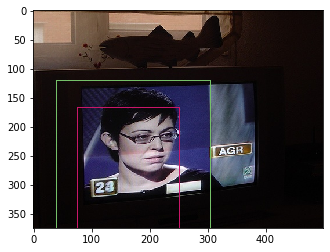

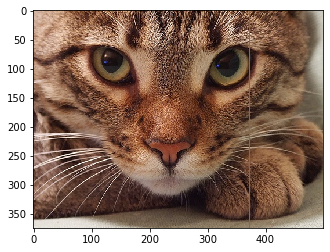

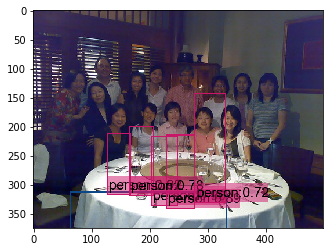

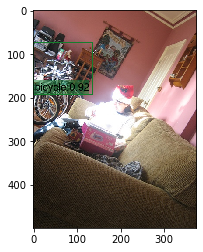

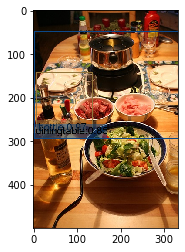

In [7]:
model.eval()
with torch.no_grad():
    for i, path in enumerate(image_paths):
        image = np.array(Image.open(path).convert("RGB"))
        height, width = image.shape[:2]
        images = transform(image)[0].unsqueeze(0)

        result = model(images.to(device))[0]
        result = result.resize((height, width)).to(cpu_device).numpy()
        boxes, labels, scores = result['boxes'], result['labels'], result['scores']
        indices = scores > 0.7
        
        boxes, labels, scores = boxes[indices], labels[indices], scores[indices]
        drawn_image = draw_boxes(image, boxes, labels, scores, class_names).astype(np.uint8)
        
        plt.imshow(drawn_image)
        #plt.subplot(1,2,1), plt.imshow(image)
        #plt.subplot(1,2,2), plt.imshow(drawn_image)
        #plt.imshow(np.hstack([image, drawn_image]))
        plt.show()